In [1]:
# dependencies
from rdkit import Chem
from rdkit.Chem import AllChem, ChemicalForceFields
from rdkit.Chem import rdmolfiles

import qml
from qml.representations import generate_fchl_acsf
from qml.kernels import get_atomic_local_kernel

import ase
from ase.visualize import view
from ase.optimize import LBFGS

import numpy as np

import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
c = qml.data.compound.Compound('../../dsgdb9nsd_050720.xyz')
#c = qml.data.compound.Compound('../../test/benzene.xyz')

In [3]:
def distance_sites(repA, repB, siteA, siteB, ZA, ZB):
    sigma = 1 # empirical
    sliceA = np.array([repA])[:,siteA:siteA+1,:]
    sliceB = np.array([repB])[:,siteB:siteB+1,:]
    
    inv_2sigma2 = -1.0 / (2 * sigma**2)
    inv_sigma2 = -1.0 / (sigma**2)
    
    q = get_atomic_local_kernel(sliceA, sliceB, np.array([ZA[siteA:siteA+1]]), np.array([ZB[siteB:siteB+1]]), sigma)[0][0]
    
    # revert transformation
    return np.log(-q/inv_sigma2)/inv_2sigma2

def distance_bn_nb(nuclear_charges, coordinates, idx_A, idx_B):
    A = nuclear_charges.copy()
    A[[idx_A, idx_B]] = (5, 7)
    B = nuclear_charges.copy()
    B[[idx_A, idx_B]] = (7, 5)
    repA, gradA = generate_fchl_acsf(A, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    repB, gradB = generate_fchl_acsf(B, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    
    delta = 0.01
    
    force = np.zeros((len(nuclear_charges), 3))
    basedist = distance_sites(repA, repB, idx_A, idx_B, A, B)
    for atomidx in range(len(nuclear_charges)):
        for dimension in range(3):
            repAprime = repA + delta * gradA[:, : , atomidx, dimension]
            repBprime = repB + delta * gradB[:, : , atomidx, dimension]
            graddist = distance_sites(repAprime, repBprime, idx_A, idx_B, A, B)
            dist = (graddist - basedist) / delta
            force[atomidx, dimension] = dist
    
    return basedist, force

%timeit distance_bn_nb(c.nuclear_charges, c.coordinates, 0, 11)

387 ms ± 63.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
import ase.calculators
class GapCalc(ase.calculators.calculator.Calculator):
    implemented_properties = 'energy forces'.split()
    
    def __init__(self, pdbfile):
        self._pdbfile = pdbfile
    
    def get_potential_energy(self, atoms=None, force_consistent=False):
        #ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        
        # add UFF forces
        self._ffmol = Chem.MolFromPDBFile(self._pdbfile, removeHs=False)
        self._ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(self._ffmol)
        self._ff = ChemicalForceFields.MMFFGetMoleculeForceField(self._ffmol, self._ffprop)
        conf = self._ffmol.GetConformer(0)
        positions = atoms.get_positions()
        for atom in range(len(positions)):
            conf.SetAtomPosition(atom, positions[atom])
        uffE = self._ff.CalcEnergy()
        
        return uffE #ds

    def get_forces(self, atoms=None):
        # QML forces
        #ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        
        # add UFF forces
        self._ffmol = Chem.MolFromPDBFile(self._pdbfile, removeHs=False)
        self._ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(self._ffmol)
        self._ff = ChemicalForceFields.MMFFGetMoleculeForceField(self._ffmol, self._ffprop)
        conf = self._ffmol.GetConformer(0)
        positions = atoms.get_positions()
        for atom in range(len(positions)):
            conf.SetAtomPosition(atom, positions[atom])
        uffgrad = np.array(self._ff.CalcGrad()).reshape(-1, 3)
        
        return -uffgrad
        return -gradds - uffgrad/100

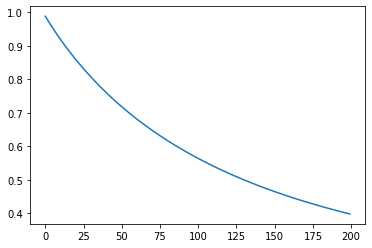

In [35]:
def do_optimisation(c, idx_A, idx_B):
    stepsize = 0.001
    maxstep = 200
    
    hist_ds = []
    coordinates = c.coordinates.copy()
    while len(hist_ds) < maxstep:
        ds, gradds = distance_bn_nb(c.nuclear_charges, coordinates, idx_A, idx_B)
        hist_ds.append(ds)
        coordinates -= stepsize*gradds
        #print ('step')
    
    plt.plot(hist_ds)
    return coordinates
cprime = do_optimisation(c, 2, 5)

In [78]:
atm = ase.Atoms(numbers=c.nuclear_charges, positions=c.coordinates, calculator=GapCalc('../../dsgdb9nsd_050720.pdb'))
dyn = LBFGS(atm, use_line_search=True,)
dyn.run(fmax=0.25)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:09:58       94.080965*     290.9398
LBFGS:    1 09:09:58       59.388402*      49.8606
LBFGS:    2 09:09:58       56.431085*      34.3545
LBFGS:    3 09:09:58       54.595503*      36.6966
LBFGS:    4 09:09:58       52.973479*      34.2417
LBFGS:    5 09:09:58       51.662126*      23.7256
LBFGS:    6 09:09:58       50.531881*      25.1031
LBFGS:    7 09:09:58       47.674755*      22.5062
LBFGS:    8 09:09:58       46.629498*      31.1776
LBFGS:    9 09:09:59       45.915845*      26.7775
LBFGS:   10 09:09:59       44.882688*      27.9833
LBFGS:   11 09:09:59       42.690675*      34.1934
LBFGS:   12 09:09:59       41.420216*      38.0105
LBFGS:   13 09:09:59       39.490685*      35.8270
LBFGS:   14 09:09:59       38.062589*      33.9888
LBFGS:   15 09:09:59       36.944129*      37.6411
LBFGS:   16 09:09:59       35.518892*      29.2858
LBFGS:   17 09:09:59       34.7098

True

In [92]:
atm.get_positions() - c.coordinates

array([[-0.04522262,  0.07686843,  0.00817217],
       [-0.07386615,  0.02687624, -0.00367231],
       [ 0.0405141 , -0.09835865,  0.02191235],
       [-0.02334856, -0.05630805, -0.02133442],
       [ 0.08806909, -0.15149021, -0.02825447],
       [ 0.02792305, -0.05499782,  0.00704322],
       [-0.03935195, -0.06313441, -0.02112681],
       [-0.00269993, -0.000416  , -0.00056905],
       [-0.00372536, -0.00184263,  0.00049143],
       [ 0.00735586, -0.17116298, -0.01421808],
       [-0.06542806, -0.05166629, -0.03970458],
       [ 0.04593963,  0.05804877, -0.03470613],
       [ 0.03231041, -0.1061683 , -0.05847673],
       [ 0.0813798 ,  0.09403571, -0.06747128],
       [-0.12612882,  0.12488949, -0.10119161],
       [-0.22187103,  0.01581493,  0.00190436],
       [-0.00703924,  0.00762703,  0.00614766]])

In [79]:
view(atm, viewer='x3d')

In [52]:
m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
#m = Chem.MolFromPDBFile('../../benzene.pdb', removeHs=False)

In [63]:
m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(m)
forcefield = ChemicalForceFields.MMFFGetMoleculeForceField(m, ffprop)

In [11]:
grad = np.array(forcefield.CalcGrad()).reshape(-1, 3)
grad

array([[  -8.3947668 , -205.95984836,  -28.29259136],
       [  -1.86831189,  221.2297927 ,   38.63018253],
       [  -7.86935451,  -16.91527336,  -20.96141911],
       [  -9.70710944,    5.22102817,    7.12291278],
       [   5.39094741,    5.5568779 ,   -3.63960982],
       [   4.23780345,  -12.98846299,   -8.20398318],
       [ -18.50045399,   -4.15062682,   12.10910783],
       [  17.47745188,  226.29110555,  181.14646159],
       [  15.88778409, -203.65937336, -175.49186892],
       [   6.86401122,   -6.11631402,   -0.80227102],
       [  -3.5330921 ,    0.64601561,    0.49525898],
       [  -4.22123453,    0.71268646,    6.88106477],
       [   2.74215631,    1.82512027,   -1.69555606],
       [  -2.692682  ,    0.65281262,    4.32941924],
       [   1.77146329,   -3.04080028,   -1.81351836],
       [  -2.85882425,    8.57855024,    5.55554523],
       [   5.27421186,  -17.88329033,  -15.36913512]])

In [68]:
scales = []
norms = []
es = []
for scale in np.linspace(0.5, 1.2, 10):
    m = Chem.MolFromPDBFile('../../dsgdb9nsd_050720.pdb', removeHs=False)
    ffprop = ChemicalForceFields.MMFFGetMoleculeProperties(m)
    forcefield = ChemicalForceFields.MMFFGetMoleculeForceField(m, ffprop)
    conf = m.GetConformer(0)
    for atom in range(c.natoms):
        conf.SetAtomPosition(atom, c.coordinates[atom]*scale)
    grad = np.array(forcefield.CalcGrad()).reshape(-1, 3)
    es.append(forcefield.CalcEnergy())
    norms.append(np.linalg.norm(grad))
    scales.append(scale)

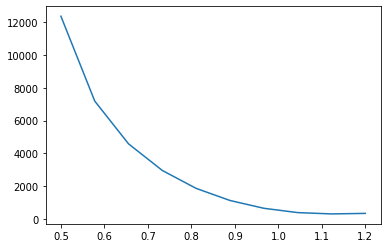

In [72]:
plt.plot(scales, norms)

In [16]:
atm.get_positions()

array([[ 0.01551954,  1.31906965,  0.16888116],
       [ 0.03811514,  0.06499798, -0.01142453],
       [ 1.3028028 , -0.78210878, -0.14853036],
       [ 1.19360693, -1.87121387, -1.04306089],
       [ 0.08254095, -2.68785091, -0.72531304],
       [-1.20153307, -1.88325954, -0.86613238],
       [-1.15662401, -0.69239017, -0.01082664],
       [-2.28555167, -0.35476206,  0.73123328],
       [-2.40041398,  0.55089715,  1.51043813],
       [ 0.96712098,  1.69016674,  0.17590973],
       [ 2.11911029, -0.15528286, -0.51398952],
       [ 1.56766647, -1.14440041,  0.86105632],
       [ 0.0918403 , -3.52366624, -1.42965796],
       [ 0.17276215, -3.086323  ,  0.29871154],
       [-1.32544442, -1.5893044 , -1.91632132],
       [-2.06701144, -2.48636061, -0.57719537],
       [-3.09735573, -1.08458235,  0.53076329]])

In [17]:
c.coordinates

array([[ 0.01551954,  1.31906965,  0.16888116],
       [ 0.03811514,  0.06499798, -0.01142453],
       [ 1.3028028 , -0.78210878, -0.14853036],
       [ 1.19360693, -1.87121387, -1.04306089],
       [ 0.08254095, -2.68785091, -0.72531304],
       [-1.20153307, -1.88325954, -0.86613238],
       [-1.15662401, -0.69239017, -0.01082664],
       [-2.28555167, -0.35476206,  0.73123328],
       [-2.40041398,  0.55089715,  1.51043813],
       [ 0.96712098,  1.69016674,  0.17590973],
       [ 2.11911029, -0.15528286, -0.51398952],
       [ 1.56766647, -1.14440041,  0.86105632],
       [ 0.0918403 , -3.52366624, -1.42965796],
       [ 0.17276215, -3.086323  ,  0.29871154],
       [-1.32544442, -1.5893044 , -1.91632132],
       [-2.06701144, -2.48636061, -0.57719537],
       [-3.09735573, -1.08458235,  0.53076329]])

In [18]:
conf.GetPositions()

array([[ 0.01551954,  1.31906965,  0.16888116],
       [ 0.03811514,  0.06499798, -0.01142453],
       [ 1.3028028 , -0.78210878, -0.14853036],
       [ 1.19360693, -1.87121387, -1.04306089],
       [ 0.08254095, -2.68785091, -0.72531304],
       [-1.20153307, -1.88325954, -0.86613238],
       [-1.15662401, -0.69239017, -0.01082664],
       [-2.28555167, -0.35476206,  0.73123328],
       [-2.40041398,  0.55089715,  1.51043813],
       [ 0.96712098,  1.69016674,  0.17590973],
       [ 2.11911029, -0.15528286, -0.51398952],
       [ 1.56766647, -1.14440041,  0.86105632],
       [ 0.0918403 , -3.52366624, -1.42965796],
       [ 0.17276215, -3.086323  ,  0.29871154],
       [-1.32544442, -1.5893044 , -1.91632132],
       [-2.06701144, -2.48636061, -0.57719537],
       [-3.09735573, -1.08458235,  0.53076329]])